### ToDo
- Train Random Forest as a baseline for each assay in the validation and test splits. For each assay, a support set of ten data points (5 active and 5 inactive molecules) will be created, on which the Random Forest will be trained, and a query set will be used to evaluate the predictions.
- Train Neural Network as a Frequent Model: All training assays will be aggregated into a pool. The neural network (Feedforward Neural Network) will be trained based on the aggregated data to achieve the best possible performance on the validation set.
- Compare the performance of the models using AUC. For Random Forest, calculate AUC for every assay and then take the mean. For NN, ???
- Filtering NaN Values: Molecules with missing values (NaN) will be removed from the training pool. The neural network will only be trained with valid data, and only molecules with labels (0 or 1) will be considered in the test set.

### Imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import itertools
from itertools import product

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler

from rdkit import Chem


#from IPython.core.display import display, HTML
#display(HTML("<style>.container { width:80% !important; }</style>"))

print(torch.cuda.is_available())
print(torch.version.cuda)  # Check PyTorch's CUDA version
print(torch.cuda.device_count())  # Number of GPUs
#print(torch.cuda.get_device_name(0))

True
12.4
1


In [2]:
# Load from pickle file
with open("datasets/datasets.pkl", "rb") as f:
    datasets = pd.read_pickle(f)

# Extract individual DataFrames
train_set_import = datasets["train"]
validation_set_import = datasets["validation"]
test_set_import = datasets["test"]

# Convert SMILES strings back to RDKit molecule objects
def postprocess_from_pickle(df):
    df = df.copy()
    df['molecule'] = df['molecule'].apply(lambda smiles: Chem.MolFromSmiles(smiles) if smiles else None)
    return df

# Apply postprocessing
train_set = postprocess_from_pickle(train_set_import)
validation_set = postprocess_from_pickle(validation_set_import)
test_set = postprocess_from_pickle(test_set_import)

[13:33:40] WARNING: not removing hydrogen atom without neighbors
[13:33:41] WARNING: not removing hydrogen atom without neighbors
[13:33:43] WARNING: not removing hydrogen atom without neighbors


In [3]:
train_set.head()

,molecule,quantilesXecfps,ATG_AR_TRANS_dn,TOX21_p53_BLA_p1_ratio,ATG_FoxA2_CIS_up,BSK_hDFCGF_TIMP1_down,ATG_LXRb_TRANS_up,Tanguay_ZF_120hpf_JAW_up,BSK_LPS_IL8_up,NVS_ADME_hCYP2D6,...,TOX21_ERa_BLA_Antagonist_ch1,NVS_ENZ_oCOX2,TOX21_ARE_BLA_Agonist_ch2,BSK_LPS_CD40_down,TOX21_Aromatase_Inhibition,BSK_hDFCGF_MCSF_down,ATG_RARa_TRANS_up,BSK_LPS_IL1a_up,TOX21_ESRE_BLA_ratio,NVS_ENZ_hBACE
0,<rdkit.Chem.rdchem.Mol object at 0x00000192B36...,"[1.3356484982591836, 1.3356484982591836, -0.38...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
1,<rdkit.Chem.rdchem.Mol object at 0x00000192B36...,"[0.9840356627736608, 0.9840356627736608, 0.100...",NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN
2,<rdkit.Chem.rdchem.Mol object at 0x00000192B36...,"[1.4329130642502799, 1.4329130642502799, -0.37...",NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,NaN
3,<rdkit.Chem.rdchem.Mol object at 0x00000192B36...,"[1.3424432672295052, 1.3424432672295052, -0.39...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,...,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,<rdkit.Chem.rdchem.Mol object at 0x00000192B36...,"[1.303283942956551, 1.303283942956551, -0.3673...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [4]:
def compute_dauprc_score(predictions, labels, target_ids):
    """
    Computes the ΔAUC-PR score for each target separately and the mean ΔAUC-PR score.
    """
    dauprcs = list()
    target_id_list = list()

    for target_idx in torch.unique(target_ids):
        rows = torch.where(target_ids == target_idx)
        preds = predictions[rows].detach()
        y = labels[rows].int()

        if torch.unique(y).shape[0] == 2:
            number_actives = y[y == 1].shape[0]
            number_inactives = y[y == 0].shape[0]
            number_total = number_actives + number_inactives

            random_clf_auprc = number_actives / number_total
            auprc = average_precision_score(
                y.numpy().flatten(), preds.numpy().flatten()
            )

            dauprc = auprc - random_clf_auprc
            dauprcs.append(dauprc)
            target_id_list.append(target_idx.item())
        else:
            dauprcs.append(np.nan)
            target_id_list.append(target_idx.item())

    return np.nanmean(dauprcs), dauprcs, target_id_list

### Random Forest

In [ ]:
def train_and_evaluate(train_function, train_data, seeds, **kwargs):
    seed_results = {}

    for seed in seeds:
        print(f"Evaluating with seed {seed}...")
        np.random.seed(seed)  # Set seed für Reproduzierbarkeit
        results, overall_mean_auc, overall_std_auc, overall_mean_dauprc, overall_std_dauprc = train_function(train_data, **kwargs)
        
        seed_results[seed] = {
            'mean_auc': overall_mean_auc,
            'std_auc': overall_std_auc,
            'mean_dauprc': overall_mean_dauprc,
            'std_dauprc': overall_std_dauprc,  # Neu: Standardabweichung ΔAUC-PR
            'results': results
        }

    # Aggregierte Ergebnisse über alle Seeds berechnen
    all_mean_aucs = [res['mean_auc'] for res in seed_results.values()]
    all_std_aucs = [res['std_auc'] for res in seed_results.values()]
    all_mean_dauprcs = [res['mean_dauprc'] for res in seed_results.values()]
    all_std_dauprcs = [res['std_dauprc'] for res in seed_results.values()]

    overall_mean_auc = np.mean(all_mean_aucs)
    overall_std_auc = np.mean(all_std_aucs)
    overall_mean_dauprc = np.mean(all_mean_dauprcs)
    overall_std_dauprc = np.mean(all_std_dauprcs)  # Neu: Gesamt-Std für ΔAUC-PR

    # Erstelle eine Zusammenfassung als DataFrame
    summary_df = pd.DataFrame(
        data={'Training Method': ['Random Forest'], 
              'Mean AUC': [f"{overall_mean_auc:.4f}"],
              'Std AUC': [f"{overall_std_auc:.4f}"],
              'Mean ΔAUC-PR': [f"{overall_mean_dauprc:.4f}"],
              'Std ΔAUC-PR': [f"{overall_std_dauprc:.4f}"]})  # Neu: Std ΔAUC-PR

    # Drucken der Zusammenfassung
    print("\nSummary of Results:")
    print(summary_df.to_string(index=False))

    return seed_results, summary_df


In [ ]:
def random_forest(train_data, n_episodes=5):
    assay_columns = [col for col in train_data.columns 
                     if col not in ['molecule', 'quantilesXecfps']]
    
    assay_results = {}
    total_assays = len(assay_columns)

    with tqdm(total=total_assays, desc="Training Assays") as pbar:
        for assay in assay_columns:
            pbar.set_postfix(current_assay=assay)

            # Entferne NaN-Werte im aktuellen Assay
            assay_data = train_data.dropna(subset=[assay])
            positive_samples = assay_data[assay_data[assay] == 1]
            negative_samples = assay_data[assay_data[assay] == 0]

            if len(positive_samples) < 5 or len(negative_samples) < 5:
                pbar.update(1)
                continue

            episode_aucs = []
            episode_dauprcs = []  # Hier sammeln wir alle ΔAUC-PR Werte

            for _ in range(n_episodes):
                # Sample Support-Set
                support_pos = positive_samples.sample(n=5)
                support_neg = negative_samples.sample(n=5)
                support_set = pd.concat([support_pos, support_neg])

                # Erstelle das Query-Set (Rest der Daten)
                query_set = assay_data.drop(support_set.index)

                # Features und Labels vorbereiten
                X_support = np.stack(support_set['quantilesXecfps'].values)
                y_support = support_set[assay].values
                X_query = np.stack(query_set['quantilesXecfps'].values)
                y_query = query_set[assay].values

                # Trainiere den Random Forest
                rf = RandomForestClassifier(random_state=None) # Place seed here
                rf.fit(X_support, y_support)

                # Evaluieren auf Query-Set
                y_pred = rf.predict_proba(X_query)[:, 1]

                # Berechnung von ROC-AUC
                episode_auc = roc_auc_score(y_query, y_pred)
                episode_aucs.append(episode_auc)

                # Berechnung von ΔAUC-PR
                y_tensor = torch.tensor(y_query)
                preds_tensor = torch.tensor(y_pred)
                target_ids = torch.full_like(y_tensor, fill_value=assay_columns.index(assay), dtype=torch.int64)
                dauprc, _, _ = compute_dauprc_score(preds_tensor, y_tensor, target_ids)
                episode_dauprcs.append(dauprc)

            # Berechne den Mittelwert und die Standardabweichung für AUC und ΔAUC-PR
            mean_assay_auc = np.mean(episode_aucs)
            std_assay_auc = np.std(episode_aucs)
            mean_assay_dauprc = np.mean(episode_dauprcs)
            std_assay_dauprc = np.std(episode_dauprcs)

            assay_results[assay] = {
                'mean_auc': mean_assay_auc,
                'std_auc': std_assay_auc,
                'mean_dauprc': mean_assay_dauprc,
                'std_dauprc': std_assay_dauprc,  # Neu: Standardabweichung ΔAUC-PR
                'episode_aucs': episode_aucs,
                'episode_dauprcs': episode_dauprcs,  
            }

            pbar.update(1)

    # Gesamtwerte über alle Assays berechnen
    overall_mean_auc = np.mean([res['mean_auc'] for res in assay_results.values()])
    overall_std_auc = np.std([res['mean_auc'] for res in assay_results.values()])
    overall_mean_dauprc = np.mean([res['mean_dauprc'] for res in assay_results.values()])
    overall_std_dauprc = np.std([res['mean_dauprc'] for res in assay_results.values()])

    print(f"Overall Mean AUC across assays: {overall_mean_auc:.4f} ± {overall_std_auc:.4f}")
    print(f"Overall Mean ΔAUC-PR across assays: {overall_mean_dauprc:.4f} ± {overall_std_dauprc:.4f}")
    print("=====================================================================")
    print("")

    return assay_results, overall_mean_auc, overall_std_auc, overall_mean_dauprc, overall_std_dauprc


In [ ]:
seeds = [0, 11942094, 23884188, 35826282, 47768376]
seeds = [0]
seed_results, summary_table = train_and_evaluate(
    train_function=random_forest,  # Pass your training function
    train_data=validation_set,  # Pass your dataset
    seeds=seeds,
    n_episodes=5  # Additional arguments for the training function
)

### Neural Network

In [5]:
# Set fixed seed for reproducibility
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [6]:
def plot_loss(loss_history):
    """Plots the training loss over epochs."""
    plt.figure(figsize=(8, 5))
    plt.plot(loss_history, label="Training Loss", color="blue")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Time")
    plt.legend()
    plt.grid()
    plt.show()

In [29]:
# Define the Frequent Hitters model with customizable hyperparameters
class FrequentHittersModel(nn.Module):
    def __init__(self, input_dim, hidden_layers=1, hidden_units=1024, dropout=0.4, layer_norm=False):
        super(FrequentHittersModel, self).__init__()
        layers = []
        for _ in range(hidden_layers):
            layers.append(nn.Linear(input_dim, hidden_units))
            if layer_norm:
                layers.append(nn.LayerNorm(hidden_units))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            input_dim = hidden_units
        layers.append(nn.Linear(input_dim, 1))
        self.model = nn.Sequential(*layers)
        self.mol_dic = mol_dic

    def forward(self, x):
        """
        Expects x to be a 1D tensor of molecule keys (IDs).
        Looks up each molecule's features from mol_dic, stacks them into a batch tensor,
        then feeds them through the network.
        """
        if x.ndim == 1:
        # Convert keys to int and extract features
            features_list = [self.mol_dic[int(key.item())] for key in x]
            features = torch.stack(features_list, dim=0)
        # If x is two-dimensional, assume it's already features
        elif x.ndim > 1:
            features = x
        else:
            raise ValueError("Unexpected input shape: {}".format(x.shape))
        out = self.model(features.float())
        return torch.sigmoid(out)

In [8]:
def initialize_model(input_dim, hyperparams, device):
    """Initialize the model with given hyperparameters."""
    model = FrequentHittersModel(
        input_dim=input_dim,
        hidden_layers=hyperparams['hidden_layers'],
        hidden_units=hyperparams['hidden_units'],
        dropout=hyperparams['dropout'],
        layer_norm=hyperparams['layer_norm']
    ).to(device)
    return model

In [9]:
def get_single_task_set(train_data):
    # Identify assay columns (excluding 'molecule' and 'quantilesXecfps')
    assay_columns = [col for col in train_data.columns if col not in ['molecule', 'quantilesXecfps']]
    
    # Melt the DataFrame to create a "SingleTask" dataset.
    single_task_data = train_data.melt(
        id_vars=['quantilesXecfps', 'molecule'],
        value_vars=assay_columns,
        var_name="Assay",
        value_name="SingleTask"
    )[["quantilesXecfps", "molecule", "SingleTask"]].dropna(subset=["SingleTask"])
    
    # Factorize the 'molecule' column to assign each unique molecule a unique integer ID.
    labels, _ = pd.factorize(single_task_data['molecule'])
    single_task_data['mol_id'] = labels
    
    # Create mol_dic: for each unique mol_id, take the first occurrence of quantilesXecfps.
    unique_rows = single_task_data.drop_duplicates(subset='mol_id')
    mol_dic = dict(zip(unique_rows['mol_id'], unique_rows['quantilesXecfps']))
    
    # Store only the keys (mol_id values) in X_train.
    X_train = single_task_data['mol_id'].values  # array of integers (keys)
    y_train = single_task_data["SingleTask"].values

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")
    X_train = torch.tensor(X_train, device=device)
    y_train = torch.tensor(y_train, device=device)
    mol_dic = {k: torch.tensor(v, device=device) for k, v in mol_dic.items()}  # Convert values to tensors
    print("Converted data to tensors.")
    
    return X_train, y_train, mol_dic

# Example usage:
X_train, y_train, mol_dic = get_single_task_set(train_set)

Using device: cuda
Converted data to tensors.


In [ ]:
mol_dic

In [ ]:
def convert_single_task(X_train, y_train):
    # Use float32 immediately to save memory
    device = torch.device("cpu")
    print(f"Using device: {device}")

    X_train = torch.tensor(X_train, dtype=torch.float32, device=device)
    y_train = torch.tensor(y_train, device=device)
    print("Converted data to float32 tensors.")

    # Move to GPU if available
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"Using device: {device}")
        X_train = X_train.to(device)
        y_train = y_train.to(device)
    
    return X_train, y_train

#X_train, y_train = convert_single_task(X_train_pre, y_train_pre)

In [ ]:
import sys
print(sys.getsizeof(X_train))  # Size in bytes
print(f"Allocated GPU Memory: {torch.cuda.memory_allocated() / (1024 ** 2):.2f} MB")
print(f"Cached GPU Memory: {torch.cuda.memory_reserved() / (1024 ** 2):.2f} MB")

In [ ]:
culprit = X_train
memory_bytes = culprit.element_size() * culprit.nelement()  # Total memory in bytes
memory_gb = memory_bytes / (1024 ** 2)  # Convert to GB

print(f"Tensor Memory Usage: {memory_gb:.4f} MB")


In [11]:
def split_support_query(evaluation_assay_data, assay, seed):
    """Splits the data into support and query sets."""
    positive_samples = evaluation_assay_data[evaluation_assay_data[assay] == 1]
    negative_samples = evaluation_assay_data[evaluation_assay_data[assay] == 0]

    if len(positive_samples) < 5 or len(negative_samples) < 5:
        return None, None

    support_pos = positive_samples.sample(n=5, random_state=seed)
    support_neg = negative_samples.sample(n=5, random_state=seed)
    support_set = pd.concat([support_pos, support_neg])

    query_set = evaluation_assay_data.drop(support_set.index)
    return support_set, query_set

In [12]:
def prepare_query_set(evaluation_data, assay, seed, device):
    """Prepares the query set for evaluation by splitting assay data."""
    evaluation_assay_data = evaluation_data.dropna(subset=[assay])
    if evaluation_assay_data.empty:
        return None, None

    # Split into support and query sets
    support_set, query_set = split_support_query(evaluation_assay_data, assay, seed)
    if query_set is None:
        return None, None

    # Extract features and labels
    X_query = torch.tensor(np.stack(query_set['quantilesXecfps'].values), dtype=torch.float32).to(device)
    y_query = torch.tensor(query_set[assay].values, dtype=torch.float32).to(device)

    return X_query, y_query

In [ ]:
def evaluate_frequent_hitters(model, evaluation_data, seed=0):
    """Evaluate the trained model on a dataset."""
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    model.eval()  # Ensure evaluation mode is activated

    evaluation_assay_columns = [col for col in evaluation_data.columns if col not in ['molecule', 'quantilesXecfps']]
    assay_results = {}

    for assay in evaluation_assay_columns:
        query_set, y_query = prepare_query_set(evaluation_data, assay, seed, device)
        if query_set is None:
            continue

        # Predict
        with torch.no_grad():
            y_pred = model(query_set).cpu().numpy().squeeze()

        # Compute AUC & ΔAUC-PR
        auc = roc_auc_score(y_query.cpu(), y_pred)
        daucprc = compute_dauprc_score(torch.tensor(y_pred), y_query.cpu(), torch.zeros_like(y_query.cpu()))[0]

        assay_results[assay] = {'auc': auc, 'daucprc': daucprc}

    # Compute metrics
    all_aucs = [res['auc'] for res in assay_results.values()]
    all_daucprcs = [res['daucprc'] for res in assay_results.values()]
    mean_auc = np.mean(all_aucs) if all_aucs else 0
    mean_daucprc = np.mean(all_daucprcs) if all_daucprcs else 0

    print(f"Mean AUC: {mean_auc:.4f}")
    print(f"Mean ΔAUC-PR: {mean_daucprc:.4f}")
    
    return mean_auc, mean_daucprc

In [36]:
from torch.utils.data import DataLoader, TensorDataset

def train_model(model, X_train, y_train, mol_dic, validation_set, hyperparams, device):
    """Train a model with early stopping based on validation AUC."""
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=hyperparams['learning_rate'], weight_decay=hyperparams['weight_decay'])

    best_auc_model = 0.0
    patience = 10
    improvement = 0.005
    epochs_no_improve = 0

    loss_history = []

    # Create a DataLoader for batching
    train_dataset = TensorDataset(X_train.to(torch.float32), y_train.to(torch.float32))
    train_loader = DataLoader(train_dataset, batch_size=hyperparams['batch_size'], shuffle=True)

    for epoch in range(hyperparams['epochs']):
        model.train()
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch + 1}/{hyperparams['epochs']}")
        
        epoch_loss = 0.0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X.to(device))
            loss = criterion(outputs, batch_y.unsqueeze(1).to(device))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        
        loss_history.append(epoch_loss / len(train_loader))

        # Validate model
        model.eval()
        auc, daucprc = evaluate_frequent_hitters(model, validation_set)

        if auc > best_auc_model + improvement:
            best_auc_model = auc
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch + 1} (no improvement in {patience} epochs)")
            break

    # Plot loss after training
    plot_loss(loss_history)

    return best_auc_model

In [15]:
def train_frequent_hitters(X_train, y_train, mol_dic, validation_set, hyperparam_grid, seed=0):
    """Find the best hyperparameters by training multiple models."""
    set_seed(seed)
    save_dir = '.'
    os.makedirs(save_dir, exist_ok=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    best_model = None
    best_auc = 0.0
    best_hyperparams = None
    results = {}

    for hyperparams in itertools.product(*hyperparam_grid.values()):
        hyperparams = dict(zip(hyperparam_grid.keys(), hyperparams))
        input_dim = int(mol_dic[0].shape[0])
        
        model = initialize_model(input_dim, hyperparams, device)

        # Train model
        best_auc_model = train_model(model, X_train, y_train, mol_dic, validation_set, hyperparams, device)

        results[str(hyperparams)] = best_auc_model

        if best_auc_model > best_auc:
            best_auc = best_auc_model
            best_model = model
            best_hyperparams = hyperparams  # Store best hyperparams

    # Save results
    results_df = pd.DataFrame.from_dict(results, orient="index", columns=["AUC"])
    results_df.to_csv(os.path.join(save_dir, "hyperparameter_results.csv"))

    print("Training completed. Best AUC:", best_auc)
    return best_model, best_hyperparams, results_df

### Hyperparameter Search

Using device: cuda
Mean AUC: 0.7694
Mean ΔAUC-PR: 0.2050
Mean AUC: 0.7777
Mean ΔAUC-PR: 0.2154
Mean AUC: 0.7815
Mean ΔAUC-PR: 0.2232
Mean AUC: 0.7830
Mean ΔAUC-PR: 0.2253
Mean AUC: 0.7839
Mean ΔAUC-PR: 0.2242
Mean AUC: 0.7861
Mean ΔAUC-PR: 0.2273
Mean AUC: 0.7870
Mean ΔAUC-PR: 0.2305
Mean AUC: 0.7865
Mean ΔAUC-PR: 0.2291
Mean AUC: 0.7874
Mean ΔAUC-PR: 0.2304
Epoch 10/100
Mean AUC: 0.7872
Mean ΔAUC-PR: 0.2310
Mean AUC: 0.7886
Mean ΔAUC-PR: 0.2300
Mean AUC: 0.7880
Mean ΔAUC-PR: 0.2304
Mean AUC: 0.7868
Mean ΔAUC-PR: 0.2284
Mean AUC: 0.7884
Mean ΔAUC-PR: 0.2294
Mean AUC: 0.7893
Mean ΔAUC-PR: 0.2320
Mean AUC: 0.7890
Mean ΔAUC-PR: 0.2328
Mean AUC: 0.7882
Mean ΔAUC-PR: 0.2328
Mean AUC: 0.7893
Mean ΔAUC-PR: 0.2332
Mean AUC: 0.7891
Mean ΔAUC-PR: 0.2319
Epoch 20/100
Mean AUC: 0.7896
Mean ΔAUC-PR: 0.2317
Mean AUC: 0.7894
Mean ΔAUC-PR: 0.2331
Mean AUC: 0.7884
Mean ΔAUC-PR: 0.2298
Mean AUC: 0.7892
Mean ΔAUC-PR: 0.2317
Mean AUC: 0.7901
Mean ΔAUC-PR: 0.2336
Mean AUC: 0.7892
Mean ΔAUC-PR: 0.2317
Mean 

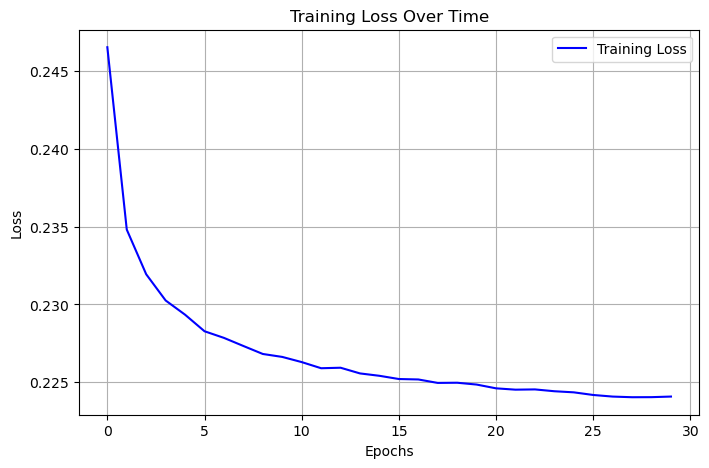

Training completed. Best AUC: 0.7896386639454342


In [35]:
hyperparam_grid = {
    'hidden_layers': [2],
    'hidden_units': [1024],
    'dropout': [0.4],
    'layer_norm': [True],
    'learning_rate': [0.01],
    'weight_decay': [0],
    'batch_size': [128],
    'epochs': [100]
}
best_model, best_hyperparams, results_df = train_frequent_hitters(X_train, y_train, mol_dic, validation_set, hyperparam_grid)

In [ ]:
hyperparam_grid = {
    'hidden_layers': [1, 2, 4],
    'hidden_units': [1024, 2048],
    'dropout': [0.4, 0.6],
    'layer_norm': [False, True],
    'learning_rate': [0.001, 0.01],
    'weight_decay': [0, 0.01],
    'batch_size': [128, 512],
    'epochs': [100]
}
best_model, best_hyperparams, results_df = train_frequent_hitters(X_train, y_train, mol_dic, validation_set, hyperparam_grid)

### Seed Testing

In [ ]:
def seed_test_model(X_train, y_train, test_set, best_hyperparams, seeds):
    """Re-trains the model with the best hyperparameters using different seeds."""
    results = {}
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    for seed in seeds:
        print(f"\n🔹 Training with Seed: {seed}")
        set_seed(seed)

        model = initialize_model(X_train.shape[1], best_hyperparams, device)
        train_model(model, X_train, y_train, test_set, best_hyperparams, device)

        # Evaluate on untouched test set
        test_auc, _ = evaluate_frequent_hitters(model, test_set)
        results[seed] = test_auc

    # Save results
    results_df = pd.DataFrame.from_dict(results, orient="index", columns=["Test AUC"])
    results_df.to_csv("seed_test_results.csv")

    print("\nSeed Testing Completed!")
    return results_df

In [ ]:
seeds = [0, 11942094, 23884188, 35826282, 47768376]
seeds = [0]
best_hyperparams = None
seed_test_model(X_train, y_train, test_set, best_hyperparams, seeds)

### Visualization

### Data Statistics

In [ ]:
import pandas as pd

# Define assay columns (excluding molecule and quantilesXecfps)
assay_cols = [col for col in train_set.columns if col not in ['molecule', 'quantilesXecfps']]

# Compute counts per molecule without modifying train_set
active_counts = train_set[assay_cols].apply(lambda row: (row.dropna() == 1).sum(), axis=1)
inactive_counts = train_set[assay_cols].apply(lambda row: (row.dropna() == 0).sum(), axis=1)
total_counts = active_counts + inactive_counts  # Total number of valid (non-NaN) assays

# Compute the percentage of actives (1s) per molecule
active_percentage = (active_counts / total_counts) * 100  # Avoids NaN issues

# Create a new DataFrame to store results
counts_df = pd.DataFrame({
    'molecule': train_set['molecule'],
    'active_count': active_counts,
    'inactive_count': inactive_counts,
    'active_percentage': active_percentage
})

# Count molecules where actives > inactives
molecules_more_active = (active_counts > inactive_counts).sum()

# Compute the percentage of molecules with more actives than inactives
total_molecules = len(train_set)
molecules_more_active_percentage = (molecules_more_active / total_molecules) * 100

# Compute the mean percentage of actives across all molecules (ignoring NaN)
mean_active_percentage = active_percentage.mean()

# Print the results
print(counts_df)
print(f"\nNumber of molecules where actives > inactives: {molecules_more_active} "
      f"({molecules_more_active_percentage:.2f}%)")
print(f"Mean percentage of actives across all molecules: {mean_active_percentage:.2f}%")


In [ ]:
# Define assay columns (excluding molecule and quantilesXecfps)
assay_cols = [col for col in train_set.columns if col not in ['molecule', 'quantilesXecfps']]

# Compute counts per molecule without modifying train_set
active_counts = train_set[assay_cols].apply(lambda row: (row.dropna() == 1).sum(), axis=1)
inactive_counts = train_set[assay_cols].apply(lambda row: (row.dropna() == 0).sum(), axis=1)
total_counts = active_counts + inactive_counts  # Total number of valid (non-NaN) assays

# Compute the percentage of actives (1s) per molecule
active_percentage = (active_counts / total_counts) * 100  # Avoids NaN issues

# Create a new DataFrame to store results
counts_df = pd.DataFrame({
    'molecule': train_set['molecule'],
    'active_count': active_counts,
    'inactive_count': inactive_counts,
    'active_percentage': active_percentage
})

# Count molecules where actives > inactives
molecules_more_active = (active_counts > inactive_counts).sum()

# Compute the mean percentage of actives across all molecules (ignoring NaN)
mean_active_percentage = active_percentage.mean()

# Print the results
print(counts_df)
print(f"\nNumber of molecules where actives > inactives: {molecules_more_active}")
print(f"Mean percentage of actives across all molecules: {mean_active_percentage:.2f}%")


In [ ]:
X_train1, y_train1 = get_single_task_set(train_set, "cpu")

In [ ]:
num_ones = (y_train1 == 1).sum().item()
num_zeros = (y_train1 == 0).sum().item()
total = y_train1.numel()

perc_ones = (num_ones / total) * 100
perc_zeros = (num_zeros / total) * 100

print(f"Count of 1s: {num_ones} ({perc_ones:.2f}%)")
print(f"Count of 0s: {num_zeros} ({perc_zeros:.2f}%)")
